In [50]:
import pandas as pd
import numpy as np
from scalecast.Forecaster import Forecaster
from scalecast.auxmodels import auto_arima
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,7)})

In [51]:
df = pd.read_excel("Case Prediction Data2.xlsx")

In [52]:
df_comp = df
df_comp.head()

,Case Number,Subject,Date Created,Date Closed,Origin,Priority,Team,Case Type,SLA,Problem Statement,Product,Product Area,Product Category,Product Type,Jurisdiction,Resolution,KB #,KB Title
0,204977,Efile Acceptance,2017-01-02 05:39:00,2017-01-03 09:03:00,Web,Medium,Tax Preparation,Efile,Platinum,We transmitted a Michigan return still have not received the acceptance/rejection confirmation.,Compliance,Returns / Reports,NaN,NaN,US.MI,Answer exists KB,041324813494120,How to understand the Transmission Monitor
1,204979,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,2017-01-02 09:03:00,2017-01-04 16:56:00,Web,High,Tax Preparation,Question / How To,Silver,Oregon STAT help: Previous Case 203787 Client needs help after 4pm CST today,Provision,State,NaN,NaN,US.OR,Customer no longer needs assistance,NaN,NaN
2,204980,Data map incorrectly pulling in values,2017-01-02 11:25:00,2017-01-03 15:48:00,Web,Medium,Tax Preparation,Question / How To,Silver,Corptax Office Import - Credit Account imports are not posting as expected,Office - Excel Add-In,Import / Export,NaN,NaN,US,Answer exists KB,041414821333274,Corptax® Office - How to place an IF formula in the Advanced formula setting of the Data Templat...
3,204981,The New Corptax Connect Website is not properly working,2017-01-02 12:06:00,2017-01-03 09:26:00,Web,High,Tax Preparation,Problem / Error,Silver,Searches can't be performed on the new system. It hasn't functioned properly since the change. ...,Websites,Connections (https://connect.corptax.com),Error Message,NaN,NaN,Answer exists KB,161216104028927,Connections Error - Uh Oh something went wrong while loading this page
4,204986,LD400 is not reflecting a temporary adjustment,2017-01-03 07:17:00,2017-01-05 08:21:00,E-mail,Medium,Tax Preparation,Problem / Error,Platinum,LD400 is not reflecting a temporary adjustment,Compliance,Returns / Reports,NaN,NaN,US,Answer exists KB,041622907012748,Adjustments do not flow to LD400 workpaper and Taxable income per the LD400 does not tie to the ...


In [103]:
#dfc = df[df.Product == "Compliance"]
# df_comp['Date Created'] = df_comp['Date Created'].dt.date
# df_comp['Date Closed'] = df_comp['Date Closed'].dt.date
df_comp['Date'] = pd.to_datetime(df_comp['Date Created'], errors='coerce')
dfc = df_comp

In [104]:
# Adding a new column which will have the number of tickets per day
newdf = dfc[["Date","Case Number"]]
newdf.drop_duplicates(inplace=True)
newdf['Date'] = pd.to_datetime(newdf['Date'])
newdf = pd.DataFrame(newdf.groupby([newdf["Date"].dt.date]).count()["Case Number"])
newdf = newdf.reset_index()
newdf.index = newdf.Date
newdf['Date'] = pd.to_datetime(newdf['Date'], errors='coerce')
newdf = newdf.asfreq('D')
newdf = newdf.groupby(pd.Grouper(freq="M")).sum()
newdf

,Case Number
Date,
2017-01-31,2206.0
2017-02-28,2377.0
2017-03-31,3326.0
2017-04-30,2186.0
2017-05-31,2581.0
...,...
2022-04-30,1871.0
2022-05-31,1787.0
2022-06-30,2112.0


In [105]:
newdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 68 entries, 2017-01-31 to 2022-08-31
Freq: M
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Case Number  68 non-null     float64
dtypes: float64(1)
memory usage: 1.1 KB


In [117]:
f = Forecaster(y=newdf['Case Number'],current_dates=newdf.index)
f.generate_future_dates(12)
f.set_test_length(.2)
f.set_estimator('arima')
f

Forecaster(
    DateStartActuals=2017-01-31T00:00:00.000000000
    DateEndActuals=2022-08-31T00:00:00.000000000
    Freq=M
    N_actuals=68
    ForecastLength=12
    Xvars=[]
    Differenced=0
    TestLength=13
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=0.95
    BootstrapSamples=100
    CurrentEstimator=arima
    GridsFile=Grids
)

In [129]:
critical_pval = 0.05
print('-'*100)
print('Augmented Dickey-Fuller results:')
stat, pval, _, _, _, _ = f.adf_test(full_res=True)
print('the test-stat value is: {:.2f}'.format(stat))
print('the p-value is {:.4f}'.format(pval))
print('the series is {}'.format('stationary' if pval < critical_pval else 'not stationary'))
print('-'*100)

----------------------------------------------------------------------------------------------------
Augmented Dickey-Fuller results:
the test-stat value is: 0.83
the p-value is 0.9922
the series is not stationary
----------------------------------------------------------------------------------------------------


# Auto-ARIMA Approach

In [118]:
auto_arima(
    f,
    start_P=1,
    start_q=1,
    max_p=10,
    max_q=10,
    m=12,
    seasonal=True,
    max_P=10, 
    max_D=10,
    max_Q=10,
    max_d=10,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    information_criterion="aic",
    alpha=0.05,
    scoring='mse',
    call_me='auto_arima',
)

Performing stepwise search to minimize aic
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=931.754, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=872.990, Time=0.12 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1042.747, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=917.428, Time=0.02 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=892.465, Time=0.12 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=884.618, Time=0.12 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=930.520, Time=0.02 sec
 ARIMA(2,0,0)(1,0,0)[12] intercept   : AIC=902.726, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=880.677, Time=0.17 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=871.423, Time=0.10 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=912.5

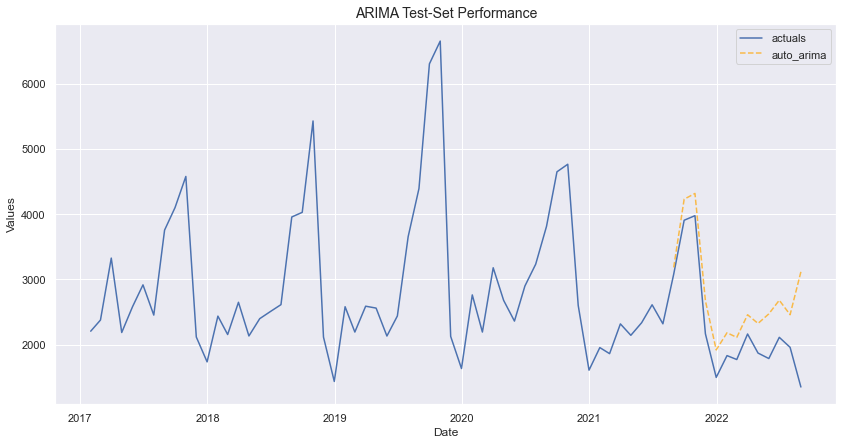

In [119]:
f.plot_test_set(ci=False,models='auto_arima')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

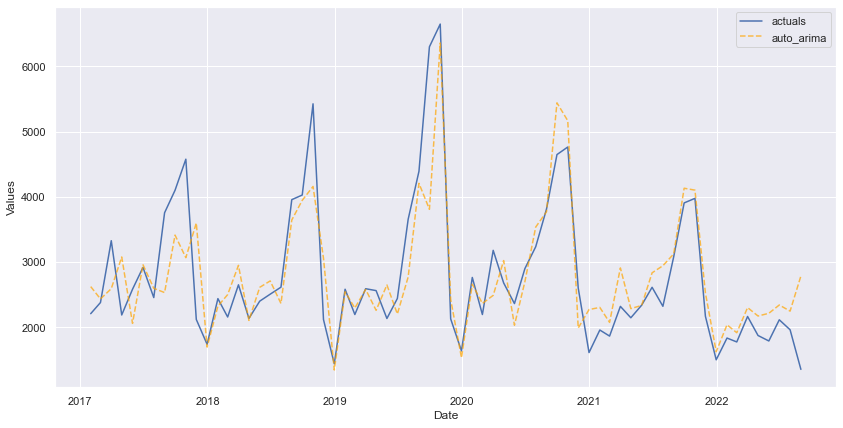

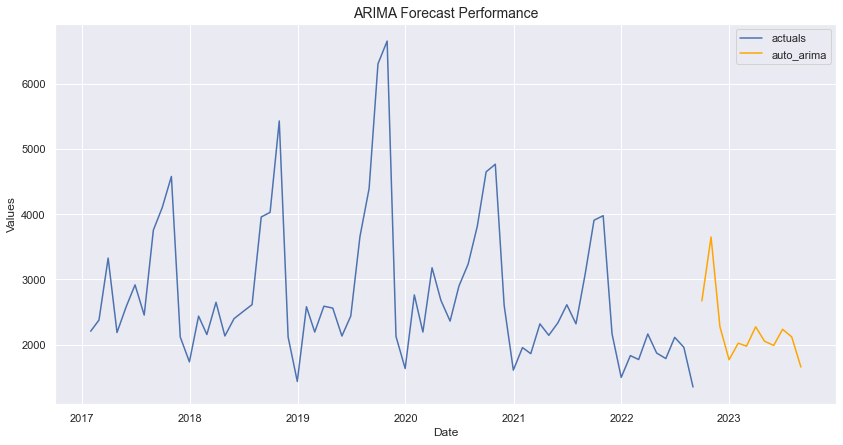

In [130]:
f.plot_fitted()
f.plot(ci=False,models='auto_arima')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

In [131]:
result_train = f.export_fitted_vals(model = "auto_arima")
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(result_train["Actuals"], result_train["FittedVals"]))
rms

607.4379740813164

In [132]:
pd.options.display.max_colwidth = 100
# results = f.export(to_excel=True,
#                    excel_name='arima_results.xlsx',
#                    determine_best_by='TestSetMAPE')
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx')
pd.set_option('display.max_columns', None)
results["model_summaries"]

,ModelNickname,Estimator,Xvars,HyperParams,Scaler,Observations,Tuned,CrossValidated,DynamicallyTested,Integration,TestSetLength,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2,LastTestSetPrediction,LastTestSetActual,CILevel,CIPlusMinus,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,ValidationSetLength,ValidationMetric,ValidationMetricValue,models,weights,LevelTestSetRMSE,LevelTestSetMAPE,LevelTestSetMAE,LevelTestSetR2,LevelInSampleRMSE,LevelInSampleMAPE,LevelInSampleMAE,LevelInSampleR2,best_model
0,auto_arima,arima,None,"{'order': (0, 0, 1), 'seasonal_order': (1, 0, 0, 12), 'trend': None}",None,68,False,False,True,0,13,641.487004,0.283972,511.514193,0.382133,3115.474364,1351.0,0.95,1184.280611,607.437974,0.15467,414.556769,0.690643,None,None,None,None,None,641.487004,0.283972,511.514193,0.382133,607.437974,0.15467,414.556769,0.690643,True


In [125]:
results.keys()

dict_keys(['model_summaries', 'best_fcst', 'all_fcsts', 'test_set_predictions', 'lvl_fcsts', 'lvl_test_set_predictions'])

In [126]:
newdf.std()

Case Number    1100.244043
dtype: float64

,ModelNickname,Estimator,Xvars,HyperParams,Scaler,Observations,Tuned,CrossValidated,DynamicallyTested,Integration,TestSetLength,TestSetRMSE,TestSetMAPE,TestSetMAE,TestSetR2,LastTestSetPrediction,LastTestSetActual,CILevel,CIPlusMinus,InSampleRMSE,InSampleMAPE,InSampleMAE,InSampleR2,ValidationSetLength,ValidationMetric,ValidationMetricValue,models,weights,LevelTestSetRMSE,LevelTestSetMAPE,LevelTestSetMAE,LevelTestSetR2,LevelInSampleRMSE,LevelInSampleMAPE,LevelInSampleMAE,LevelInSampleR2,best_model
0,auto_arima,arima,None,"{'order': (0, 0, 1), 'seasonal_order': (1, 0, 0, 12), 'trend': None}",None,68,False,False,True,0,13,641.487004,0.283972,511.514193,0.382133,3115.474364,1351.0,0.95,1184.280611,607.437974,0.15467,414.556769,0.690643,None,None,None,None,None,641.487004,0.283972,511.514193,0.382133,607.437974,0.15467,414.556769,0.690643,True


In [ ]:
# Test RMSE: 641.48
# Mean: 2782.17
# Std: 1100.24

In [116]:
results["lvl_fcsts"]

,DATE,auto_arima
0,2022-09-30,2671.179224
1,2022-10-31,3649.627212
2,2022-11-30,2275.746155
3,2022-12-31,1768.700549
4,2023-01-31,2022.223352
5,2023-02-28,1976.680334
6,2023-03-31,2273.469004
7,2023-04-30,2051.826314
8,2023-05-31,1988.066088
9,2023-06-30,2234.757438


# ########

In [45]:
d1 = results["test_set_predictions"][["DATE","arima3"]]
d2 = results["all_fcsts"][["DATE","arima3"]]

In [60]:
d_pred = pd.concat([d1,d2],axis=0)
d_pred

,DATE,arima3
55,2021-08-31,3183.451538
56,2021-09-30,4228.332149
57,2021-10-31,4316.476384
58,2021-11-30,2672.130491
59,2021-12-31,1919.105177
60,2022-01-31,2182.018152
61,2022-02-28,2111.350792
62,2022-03-31,2457.848817
63,2022-04-30,2324.872601
64,2022-05-31,2471.526371


In [61]:
d_pred.to_csv("file.csv",index=False)

In [62]:
newdf.reset_index().to_csv("file2.csv",index=False)

In [56]:
origin_df["arima3"] = np.NAN

In [57]:
origin_df

,Date,Case Number,arima3
0,2017-01-31,2206.0,NaN
1,2017-02-28,2377.0,NaN
2,2017-03-31,3326.0,NaN
3,2017-04-30,2186.0,NaN
4,2017-05-31,2581.0,NaN
...,...,...,...
63,2022-04-30,1871.0,NaN
64,2022-05-31,1787.0,NaN
65,2022-06-30,2112.0,NaN
66,2022-07-31,1959.0,NaN


In [58]:
pd.concat(origin_df,d_pred)

ValueError: Merge keys contain null values on left side

In [37]:
import plotly.express as px
fig = px.line(origin_df, x='Date', y="Case Number")
fig.show()

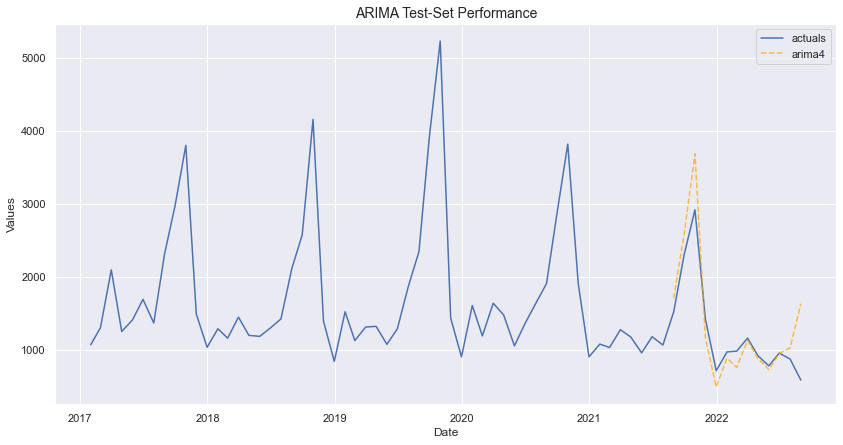

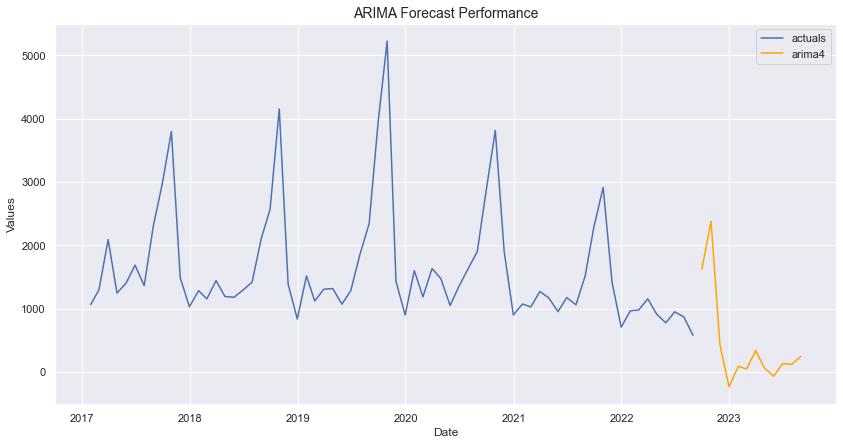

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   68
Model:             ARIMA(1, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -408.452
Date:                            Fri, 26 Aug 2022   AIC                            824.904
Time:                                    16:51:44   BIC                            832.933
Sample:                                         0   HQIC                           828.009
                                             - 68                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2737      0.188     -1.454      0.146      -0.643       0.095
ar.S.L12       0.3900      0.330      1.182      0.237      -0.257       1.037
ma.S.L12      -0.9902     10.486     -0.094      0.925     -21.541      19.561
sigma2      1.333e+05   1.36e+06      0.098      0.922   -2.53e+06     2.8e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.61   Jarque-Bera (JB):                12.44
Prob(Q):                              0.44   Prob(JB):                         0.00
Heteroskedasticity (H):               0.75   Skew:                             0.46
Prob(H) (two-sided):                  0.54   Kurtosis:                         5.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [215]:
f.set_validation_length(12)
grid = {
    'order':[(1,1,1),(1,1,0),(0,1,1)],
    'seasonal_order':[(2,1,1,12),(1,1,1,12),(2,1,0,12),(0,1,0,12)]
}

f.ingest_grid(grid)
f.tune()
f.auto_forecast(call_me='arima4')

f.plot_test_set(ci=False,models='arima4')
plt.title('ARIMA Test-Set Performance',size=14)
plt.show()

f.plot(ci=False,models='arima4')
plt.title('ARIMA Forecast Performance',size=14)
plt.show()

f.regr.summary()

In [216]:
pd.options.display.max_colwidth = 100
results = f.export(to_excel=True,
                   excel_name='arima_results.xlsx',
                   determine_best_by='TestSetMAPE')

In [217]:
results["test_set_predictions"]
results["all_fcsts"]

,DATE,actual,arima4,arima2,arima3,arima1
55,2021-08-31,1517.0,1702.625656,1864.583179,1889.436807,1711.981871
56,2021-09-30,2300.0,2582.738084,2511.477406,3386.024467,1711.981871
57,2021-10-31,2915.0,3682.114872,3633.539862,4377.117595,1711.981871
58,2021-11-30,1417.0,1161.872889,1299.856642,1718.021872,1711.981871
59,2021-12-31,710.0,487.171588,655.024484,895.707528,1711.981871
60,2022-01-31,968.0,879.611172,972.754895,1298.928629,1711.981871
61,2022-02-28,979.0,756.989674,883.125150,1094.670314,1711.981871
62,2022-03-31,1157.0,1125.841442,1230.653855,1424.927616,1711.981871
63,2022-04-30,914.0,874.646439,942.788336,1298.279566,1711.981871
64,2022-05-31,777.0,725.686055,904.774353,995.411103,1711.981871


In [218]:
results["all_fcsts"]

,DATE,arima1,arima2,arima3,arima4
0,2022-09-30,1620.819437,1932.067910,1889.421139,1625.693075
1,2022-10-31,1620.819437,2981.945128,2733.757837,2382.789529
2,2022-11-30,1620.819437,791.024890,1294.865269,430.849719
3,2022-12-31,1620.819437,236.550741,619.085756,-235.628436
4,2023-01-31,1620.819437,619.801875,909.955076,90.661312
5,2023-02-28,1620.819437,525.169692,940.730385,48.910194
6,2023-03-31,1620.819437,854.534913,1144.475346,338.270787
7,2023-04-30,1620.819437,549.847584,931.090655,62.277341
8,2023-05-31,1620.819437,428.037525,790.075445,-64.500533
9,2023-06-30,1620.819437,631.389797,975.325472,133.178434
